In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt


In [23]:
# กำหนดพาธของข้อมูล
data_train_path = 'Fruits_Vegetables/train'
data_val_path = 'Fruits_Vegetables/validation'
data_test_path = 'Fruits_Vegetables/test'


In [24]:
# กำหนดขนาดภาพและ batch size
img_size = (180, 180)
batch_size = 32


In [25]:
# โหลดข้อมูลพร้อมทำ Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

dataset_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size
)

dataset_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    shuffle=False,
    image_size=img_size,
    batch_size=batch_size
)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


In [26]:
# ใช้ EfficientNetB0 เป็น Backbone Model
base_model = EfficientNetB0(include_top=False, input_shape=(180, 180, 3), weights='imagenet')
base_model.trainable = False  # ล็อคค่าเริ่มต้นของโมเดล

# สร้างโมเดล
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(dataset_train.class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [28]:
# คอมไพล์โมเดล
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ฝึกโมเดล
epochs = 50
history = model.fit(dataset_train, validation_data=dataset_val, epochs=epochs)

Epoch 1/50


98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.8220 - loss: 0.7159 - val_accuracy: 0.9145 - val_loss: 0.3504
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.8523 - loss: 0.5617 - val_accuracy: 0.9345 - val_loss: 0.2978
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.8698 - loss: 0.4760 - val_accuracy: 0.9373 - val_loss: 0.2660
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.8858 - loss: 0.4290 - val_accuracy: 0.9402 - val_loss: 0.2443
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.8963 - loss: 0.3796 - val_accuracy: 0.9373 - val_loss: 0.2313
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.8949 - loss: 0.3636 - val_accuracy: 0.9430 - val_loss: 0.2137
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.9124 - loss: 0.3364 - val_accuracy: 0.9487 - val_loss: 0.2021
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.9284 - loss: 0.3004 - val_accuracy: 0.954

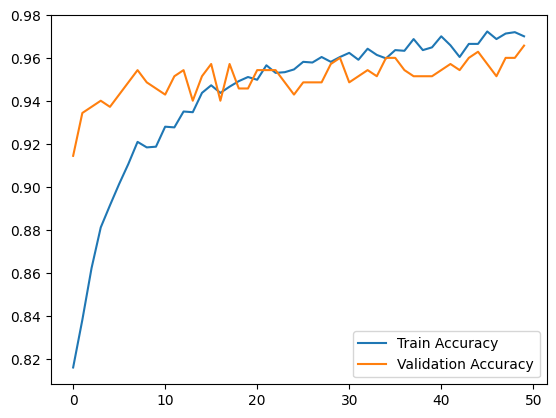

In [29]:
# แสดงผลกราฟความแม่นยำ
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [30]:
# ปลดล็อคบางชั้นของ EfficientNetB0 และฝึกต่อ (Fine-tuning)
base_model.trainable = True
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 5
history_fine = model.fit(dataset_train, validation_data=dataset_val, epochs=fine_tune_epochs)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 104s 837ms/step - accuracy: 0.6963 - loss: 1.0024 - val_accuracy: 0.9430 - val_loss: 0.1606
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 836ms/step - accuracy: 0.8561 - loss: 0.4311 - val_accuracy: 0.9487 - val_loss: 0.1467
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 94s 954ms/step - accuracy: 0.8933 - loss: 0.3224 - val_accuracy: 0.9544 - val_loss: 0.1500
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 869ms/step - accuracy: 0.9309 - loss: 0.2048 - val_accuracy: 0.9516 - val_loss: 0.1413
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 87s 884ms/step - accuracy: 0.9365 - loss: 0.1959 - val_accuracy: 0.9601 - val_loss: 0.1307


In [31]:
# บันทึกโมเดล
model.save("fruit_veg_classifier.h5")